In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
from binance.client import Client
import time
import statistics as stats
from datetime import datetime
import random
import torch
import torch.nn as nn
import mlfinlab as ml
import glob
import matplotlib
from sklearn.linear_model import LogisticRegression

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
coin_list=['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']

In [4]:
weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/breadwinner/'
model_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork/'
#best_weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/best_model'

In [5]:
li=[]

all_files = glob.glob(model_path + "/*.pth")

for i in range(len(all_files)):
    print(all_files[i])
    x=torch.load(all_files[i])
    li.append(x)

E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_ADA.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_BNB.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_ETH.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_LINK.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_LTC.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_normalized_ADA.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_normalized_BNB.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_normalized_ETH.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_normalized_LINK.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_normalized_LTC.pth
E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\model_norma

In [6]:
all_files

['E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_ADA.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_BNB.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_ETH.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_LINK.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_LTC.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_normalized_ADA.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_normalized_BNB.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_normalized_ETH.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_normalized_LINK.pth',
 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/mightwork\\model_normalized_LTC.pth',
 'E:/Users/Justin/Desktop/Course 

In [7]:
ADA_model = li[5]
BNB_model = li[1]
ETH_model = li[2]
LINK_model = li[3]
LTC_model = li[4]
XRP_model = li[-2]

In [8]:
model_dict={'ADA': ADA_model, 'BNB': BNB_model, 'ETH': ETH_model, 'LINK': LINK_model, 'LTC': LTC_model, 'XRP': XRP_model}

In [124]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, linear_hidden=52):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.l1 = nn.Linear(hidden_dim, linear_hidden).to(device)
        self.l2 = nn.Linear(linear_hidden, output_dim).to(device)
        self.batch_norm1=nn.BatchNorm1d(hidden_dim)
        self.batch_norm2=nn.BatchNorm1d(linear_hidden)
        self.sigmoid=nn.Sigmoid()
        self.drop = nn.Dropout(.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        output, (hn, cn) = self.lstm(x.to(device), (h0.detach().to(device), c0.detach().to(device)))
        output=self.batch_norm1(output.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.l1(output[:, -1, :])
        out=self.l2(self.batch_norm2(self.sigmoid(out)))
        return out

In [10]:
df_dict = {}

directory = '../data/final_data' ### directory with final data
all_files = glob.glob(directory + "/*.csv")

for file in all_files:
    
    df = pd.read_csv(file, index_col=None, header=0)
    df_dict[file.split('\\')[1][:-10]] = df ### df dictionary with keys ADA, BNB, ...

In [11]:
columns = list(df_dict[coin_list[0]].columns)
not_quant = ['Open Time','Close Time', 'bin'] ### take out label and non-quantitative data 
quants = [i for i in columns if i not in not_quant][1:]

In [12]:
def separate(data, break_point=.15, window_length=.05, desired_feature=4):
    
    #separate into training, testing data 
    
    upper=int((1-break_point) * data.shape[0]) + int(window_length * data.shape[0])
    lower=int((1-break_point) * data.shape[0]) - int(window_length * data.shape[0])
    
    train_x, train_y = data[:lower, :, :], data[1:lower+1, -1, desired_feature]
    test_x, test_y = data[upper:-1], data[upper+1:, -1, desired_feature]
    
    return train_x, train_y, test_x, test_y

In [13]:
class Create_Sequences():
    def __init__(self, data, seq_len=25): ### feed in df_dict[coin], sequence length
        self.seq_len = seq_len       
        self.sequences = []
        self.data = data
        self.create_sequences()

    def create_sequences(self):
        
        self.data = torch.tensor(self.data[quants].values)
        
        for i in range(self.data.shape[0] - self.seq_len):

            sequence=self.data[i:i+self.seq_len] #i, .., i+seq_len-1, i+seq_len
            self.sequences.append(sequence)
            
        self.sequences=torch.stack(self.sequences)#shape of data - seq_len, sequence length, # of features
       

In [14]:
data=df_dict['ETH']

## labeling

In [15]:
data.columns

Index(['Unnamed: 0', 'Open Time', 'Time of Day', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Close Time', 'Quote asset vol', 'Num trades',
       'Taker buy base asset volume', 'Taker buy quote asset volume', 'Status',
       'bin', 'Close_pct', 'Open_pct', 'High_pct', 'Low_pct', 'SMA', 'EMA',
       'DEMA', 'TEMA', 'KAMA', 'mama', 'fama', 'MIDPOINT', 'MIDPRICE',
       'BB_upper', 'BB_ema', 'BB_lower', 'ADX', 'ADXR', 'AROONOSC', 'BOP',
       'CCI', 'CMO', 'MACD', 'MACD Signal', 'MFI', 'PPO', 'ROC', 'ROCP',
       'ROCR', 'ROCR100', 'RSI', 'fastk', 'fastd', 'SAR', 'ULTOSC', 'WILLR',
       'AD', 'ADOSC', 'OBV', 'ATR', 'NATR', 'Spinning Top'],
      dtype='object')

In [16]:
data['BB_bin']=0

In [17]:
for i in data.index:
    if data['Close'][i] > data['BB_upper'][i]:
        data['BB_bin'][i]=-1
    elif data['Close'][i] < data['BB_lower'][i]:
        data['BB_bin'][i]=1     

In [18]:
data['BB_bin'].value_counts()

 0    50963
 1     3940
-1     3302
Name: BB_bin, dtype: int64

In [19]:
data['budget_tbm']=0

In [20]:
for i in data.index[:-25]:
    
    for j in range(25):
     
        if data['BB_upper'][i] < data['Close'][i:i+25].values[j] or data['BB_lower'][i] > data['Close'][i]:
            data['budget_tbm'][i] = 1
            break
    
        elif data['BB_lower'][i] > data['Close'][i:i+25].values[j] or data['BB_upper'][i] < data['Close'][i]:
            data['budget_tbm'][i]=-1
            break

In [21]:
data['budget_tbm'].value_counts()

 1    24724
-1    20736
 0    12745
Name: budget_tbm, dtype: int64

In [22]:
data.shape

(58205, 59)

In [23]:
data['dumb_labels']=0

In [24]:
for i in data.index[1:-1]:
    if data['Close'][i-1] < data['Close'][i] and data['Close'][i] > data['Close'][i+1]:
        data['dumb_labels'][i] = -1
    elif data['Close'][i-1] > data['Close'][i] and data['Close'][i] < data['Close'][i+1]:
        data['dumb_labels'][i] = 1
    

In [25]:
data['dumb_labels'].value_counts()

 0    27838
-1    15197
 1    15170
Name: dumb_labels, dtype: int64

In [26]:
data['I_saw_this_somewhere']=0

In [27]:
for i in data.index[:-13]:
    if max(data['Close'][i:i+13])==data['Close'][i+7]:
        data['I_saw_this_somewhere'][i] = -1
    elif min(data['Close'][i:i+13])==data['Close'][i+7]:
        data['I_saw_this_somewhere'][i] = 1

In [28]:
data['I_saw_this_somewhere'].value_counts()

 0    51757
 1     3254
-1     3194
Name: I_saw_this_somewhere, dtype: int64

In [29]:
data['Close'][:25].shape

(25,)

In [30]:
sub_df=data[quants]

In [31]:
sub_df.shape

(58205, 53)

In [32]:
data['budget_tbm']

0        0
1        0
2        0
3        0
4        1
        ..
58200    0
58201    0
58202    0
58203    0
58204    0
Name: budget_tbm, Length: 58205, dtype: int64

## convert all data into 25 sequence tensor

In [33]:
#data_25_sequences=Create_Sequences(sub_df, 25)
#tensored_data_25=data_25_sequences.sequences

## network testing

In [34]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([4, 1, 3])

In [35]:
torch.randn(3, 5, requires_grad=True)

tensor([[ 0.2301, -0.0761,  1.4232,  0.6374,  2.3724],
        [ 0.2428,  0.2650, -0.7417, -0.2958,  0.7790],
        [ 0.7050,  0.2612, -0.2548,  0.3897,  0.3112]], requires_grad=True)

In [36]:
m = nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)
output.shape

torch.Size([20, 16])

In [37]:
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
m = nn.BatchNorm2d(100, affine=False)
input = torch.randn(1, 100, 35, 45)
output = m(input)
output.shape

torch.Size([1, 100, 35, 45])

## Training Using budget_tbm

In [53]:
budget_tbm=torch.tensor(data['budget_tbm'])

In [54]:
budget_tbm.shape

torch.Size([58205])

In [55]:
sequence_length=50
data_50_sequences=Create_Sequences(sub_df, sequence_length)
x_training=data_50_sequences.sequences[:-6_000]
x_testing=data_50_sequences.sequences[-4_500:]

In [56]:
x_training.shape

torch.Size([52155, 50, 53])

In [92]:
x_testing.shape

torch.Size([4500, 50, 53])

In [93]:
labels=[1, -1, 0]
y_training=[]
for i in budget_tbm:
    y_training.append(labels.index(i))
y_training=torch.tensor(y_training)[sequence_length:-6_000]
y_testing=torch.tensor(y_training)[-4_500:]


In [94]:
y_training.shape

torch.Size([52155])

In [95]:
y_testing.shape

torch.Size([4500])

In [57]:
'''
y_training=budget_tbm[sequence_length:-6_000]
y_training.shape
y_testing=budget_tbm[-4_500:]
'''

In [60]:
x_testing.shape

torch.Size([4500, 50, 53])

In [65]:
torch.unique(y_testing, return_counts=True)

(tensor([-1,  0,  1]), tensor([1780,  952, 1768]))

In [66]:
colors=['red', 'blue', 'green']

In [67]:
data['Close'].values[-4500:]

array([0.036042, 0.03606 , 0.036063, ..., 0.028055, 0.028061, 0.0281  ])

In [71]:
len(range(4_500))

4500

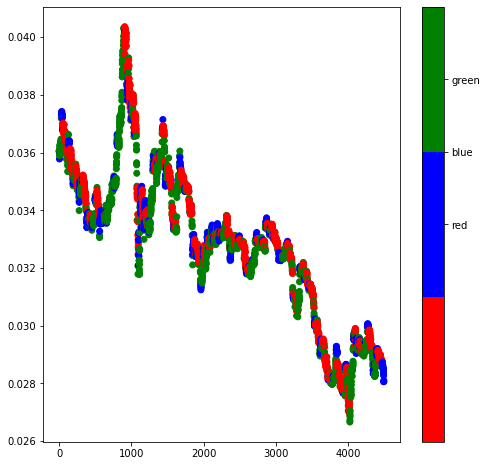

In [73]:
fig = plt.figure(figsize=(8,8))
plt.scatter(range(4_500), data['Close'].values[-4_500:], c=y_testing, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(y_testing),max(y_testing)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [126]:
input_dim = 53
hidden_dim = 300
n_layers = 5
output_dim = 3

model = LSTM(input_dim, hidden_dim, n_layers, output_dim)
model=model.to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [ ]:
'''
ideas:
data selection, cluster sampling
bootstrapping
k-fold cross validation
'''

In [127]:
epochs=1_000
time_list=[]
loss_list=[]
torch.cuda.empty_cache()
model.train()

for i in range(epochs):

    indices=random.sample(range(x_training.shape[0]), k=100)
    sequences=x_training[indices].to(device)
    labels=y_training[indices].to(device)
    
    start=time.time()
    
    optimizer.zero_grad()
    prediction=model(sequences.float())
    loss=criterion(prediction, labels.long())
    
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    end=time.time()
    
    time_list.append(end-start)
    
    if i%50==0 or i==epochs-1:
        torch.save(model.state_dict(), weights_path+'test.pth')
        print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])

Epoch:  0 Time:  0.15259075164794922 Loss:  1.2482491731643677
Epoch:  50 Time:  0.049866676330566406 Loss:  1.0114800930023193
Epoch:  100 Time:  0.05485343933105469 Loss:  1.0628814697265625
Epoch:  150 Time:  0.057845354080200195 Loss:  1.1263357400894165
Epoch:  200 Time:  0.05186057090759277 Loss:  1.033543586730957
Epoch:  250 Time:  0.05186176300048828 Loss:  1.0656867027282715
Epoch:  300 Time:  0.05086398124694824 Loss:  1.0644134283065796
Epoch:  350 Time:  0.05285930633544922 Loss:  1.1064238548278809
Epoch:  400 Time:  0.05086493492126465 Loss:  1.038280963897705
Epoch:  450 Time:  0.05186104774475098 Loss:  1.0625554323196411
Epoch:  500 Time:  0.05186152458190918 Loss:  1.0712213516235352
Epoch:  550 Time:  0.05385589599609375 Loss:  1.0845319032669067
Epoch:  600 Time:  0.05385589599609375 Loss:  1.0678589344024658
Epoch:  650 Time:  0.050864219665527344 Loss:  1.0995190143585205
Epoch:  700 Time:  0.050864219665527344 Loss:  1.1068938970565796
Epoch:  750 Time:  0.05186

In [128]:
with torch.no_grad():
    results=[]
    for i in x_testing:
        results.append(model(i.reshape(1,i.shape[0], i.shape[1]).float()))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 52])